In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

### Import data

In [96]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl"))

### preprocessing

In [97]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_input=[df_Ch001, df_Ch009, df_Ch020]
df_input_scaled=[]
LOG_SCALE= False

if LOG_SCALE:
    for df in df_input:

        df_log=df.copy()
        df_log[df_log<=0] = 0.08
        df_log=df_log.apply(lambda x: np.log10(x))
        scaler=MinMaxScaler()
        scaler.fit(df_log)
        df_input_scaled.append(pd.DataFrame(scaler.transform(df_log), index=df_Ch022.index, columns=df_Ch022.columns))

    df_output_scaled=df_Ch022.copy()
    df_output_scaled[df_output_scaled<=0 ] = 0.08
    df_output_scaled=df_output_scaled.apply(lambda x: np.log10(x))
    output_scaler=MinMaxScaler()
    output_scaler.fit(df_output_scaled)
    df_output_scaled[:]=output_scaler.transform(df_output_scaled)

else:
    for df in df_input:
        scaler=MinMaxScaler()
        scaler.fit(df)
        df_input_scaled.append(pd.DataFrame(scaler.transform(df), index=df_Ch022.index, columns=df_Ch022.columns))

        output_scaler=MinMaxScaler()
        output_scaler.fit(df_Ch022)
        df_output_scaled=pd.DataFrame(output_scaler.transform(df_Ch022), index=df_Ch022.index, columns=df_Ch022.columns)

### Choosing L 

In [124]:
p=34

### plot intput scale

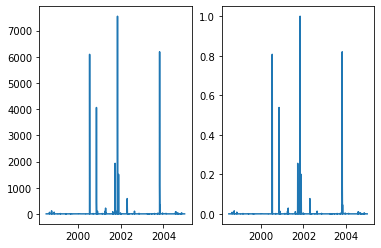

In [125]:
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.plot(df_Ch022.index, df_input[0].iloc[:,p])
ax2.plot(df_Ch022.index, df_input_scaled[0].iloc[:,p])

### plot target scale

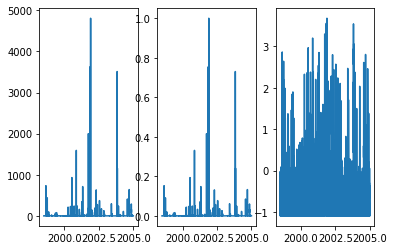

In [126]:
#log vs minmax
df_test=df_Ch022.copy()
df_test[df_test<=0 ] = 0.08
fig, (ax1, ax2, ax3)= plt.subplots(1,3)
ax1.plot(df_Ch022.index, df_Ch022.iloc[:,p])
ax2.plot(df_Ch022.index, df_output_scaled.iloc[:,p])
ax3.plot(df_Ch022.index, df_test.apply(lambda x: np.log10(x)).iloc[:,p])


### Split data

In [101]:
import torch
from sklearn.model_selection import train_test_split

In [102]:
split_data=int(len(df_Ch022.index)*0.9)

data_1=df_input_scaled[0].iloc[:split_data,p].values
data_2=df_input_scaled[1].iloc[:split_data,p].values
data_3=df_input_scaled[2].iloc[:split_data,p].values

data=np.vstack((data_1, data_2, data_3)).T

target=df_output_scaled.iloc[:,p].copy()
target=target.iloc[:split_data].values[:,np.newaxis]

In [103]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=20)
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

In [104]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [105]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=3399)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=850)

### ANN model

In [106]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(3, 40)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating Model, Optimizer and Loss

In [107]:
# creating model,and defining optimizer and loss
model = ReLUNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [108]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [109]:
# defining the number of epochs
epochs = 1000
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [110]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [111]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [112]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [113]:
checkpointer = ModelCheckpoint(Path('./saved_models'), 'ANN_v2_minMAXX', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {str(p): model})

### Run Engine

In [114]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch: 1  Avg loss: 0.02
Validation Results - Epoch: 1  Avg loss: 0.02
Training Results - Epoch: 2  Avg loss: 0.02
Validation Results - Epoch: 2  Avg loss: 0.02
Training Results - Epoch: 3  Avg loss: 0.02
Validation Results - Epoch: 3  Avg loss: 0.02
Training Results - Epoch: 4  Avg loss: 0.01
Validation Results - Epoch: 4  Avg loss: 0.02
Training Results - Epoch: 5  Avg loss: 0.01
Validation Results - Epoch: 5  Avg loss: 0.01
Training Results - Epoch: 6  Avg loss: 0.01
Validation Results - Epoch: 6  Avg loss: 0.01
Training Results - Epoch: 7  Avg loss: 0.01
Validation Results - Epoch: 7  Avg loss: 0.01
Training Results - Epoch: 8  Avg loss: 0.01
Validation Results - Epoch: 8  Avg loss: 0.01
Training Results - Epoch: 9  Avg loss: 0.01
Validation Results - Epoch: 9  Avg loss: 0.01
Training Results - Epoch: 10  Avg loss: 0.01
Validation Results - Epoch: 10  Avg loss: 0.01
Training Results - Epoch: 11  Avg loss: 0.01
Validation Results - Epoch: 11  Avg loss: 0.01
Traini

State:
	iteration: 34
	epoch: 34
	epoch_length: 1
	max_epochs: 1000
	output: 0.000849013333208859
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

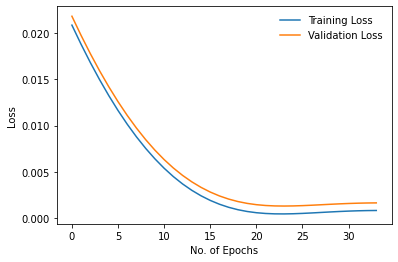

In [115]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [120]:
model.load_state_dict(torch.load(Path("C:/Users/Victor/Desktop/PIR/model/saved_models/ANN_v2_34_683.pt")))
print("Model Loaded")

Model Loaded


In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
model.to("cpu")

data_1_test=df_input_scaled[0].iloc[:,p].values
data_2_test=df_input_scaled[1].iloc[:,p].values
data_3_test=df_input_scaled[2].iloc[:,p].values

data_test=np.vstack((data_1_test, data_2_test, data_3_test)).T
data_test=torch.tensor(data_test).float()
y_test=df_output_scaled.iloc[:, p].values

y_pred_test=model(data_test).detach().numpy()
MSE=mean_squared_error(y_test, y_pred_test)
print(MSE)

min=output_scaler.data_min_[p]
max=output_scaler.data_max_[p]
print(min, max)
y_pred_test=(max-min)*y_pred_test+min
if LOG_SCALE:
    y_pred_test=10 ** y_pred_test


0.00034415791439864225
-1.0 4809.0


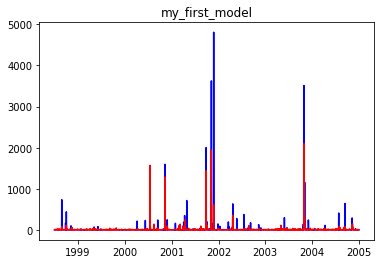

In [123]:
    plt.figure()
    plt.plot(df_Ch022.index[:], df_Ch022.iloc[:,p], color= "blue")
    plt.plot(df_Ch022.index[:], y_pred_test, color="red")
    plt.title("my_first_model")

    plt.show()